In [1]:
import pandas as pd
import autograd.numpy as np
from autograd import grad 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from common import gradient_descent, plot_cost_histories

In [2]:
# Read data
DATA_BASE_URL = "https://raw.githubusercontent.com/sql-injection/spotify_data/master/"
datasets = {
    "train": DATA_BASE_URL + "train.csv",
    "test": DATA_BASE_URL + "test.csv",
    "all": DATA_BASE_URL + "spotify.csv"
}

total_df = pd.read_csv(datasets["all"])
train_df = pd.read_csv(datasets["train"])
test_df = pd.read_csv(datasets["test"])
attribute_names = list(train_df)[:-1]

# Split test and training into x and y values
x_train = train_df[attribute_names]
y_train = train_df["Class"]
x_test = test_df[attribute_names]
y_test = test_df["Class"]

x = x_train
y = y_train
x = x.values
y = y.values

original_x = np.copy(x)
original_y = np.copy(y)

In [3]:
genre_histograms = {
    "edm":       np.asarray([1, 0, 0, 0, 0, 0, 0]),
    "hiphop":    np.asarray([0, 1, 0, 0, 0, 0, 0]),
    "classical": np.asarray([0, 0, 1, 0, 0, 0, 0]),
    "jazz":      np.asarray([0, 0, 0, 1, 0, 0, 0]),
    "pop":       np.asarray([0, 0, 0, 0, 1, 0, 0]),
    "country":   np.asarray([0, 0, 0, 0, 0, 1, 0]),
    "rock":      np.asarray([0, 0, 0, 0, 0, 0, 1])
}

In [4]:
# Genre encoded into one-hot vectors
y_encoded = np.array([genre_histograms[genre] for genre in y])

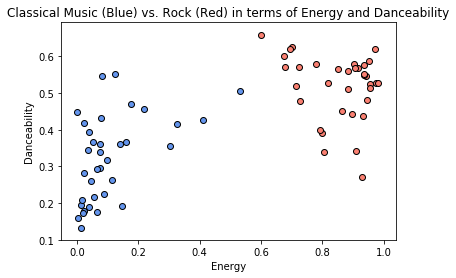

In [5]:
feature_a_indices =  np.where(y == "classical")[0]
feature_b_indices = np.where(y == "rock")[0]
feature_a_color = "cornflowerblue";
feature_b_color = "salmon";

attribute_names = np.array(attribute_names)
energy_attribute_index = np.where(attribute_names == "energy")[0][0]
danceability_attribute_index = np.where(attribute_names == "danceability")[0][0]

f = plt.figure()
ax = plt.subplot()
ax.set_xlabel("Energy")
ax.set_ylabel("Danceability")
ax.set_title("Classical Music (Blue) vs. Rock (Red) in terms of Energy and Danceability")
for i in feature_a_indices:
    ax.scatter(original_x[i, energy_attribute_index],
               original_x[i, danceability_attribute_index],
               color=feature_a_color, edgecolor='k')
    
for i in feature_b_indices:
    ax.scatter(original_x[i, energy_attribute_index],
               original_x[i, danceability_attribute_index],
               color=feature_b_color, edgecolor='k')


In [6]:
X = original_x[:, :2]
included_indices = np.concatenate((feature_a_indices, feature_b_indices))
X = np.take(X, included_indices, axis=0)
Y = np.take(original_y, included_indices, axis=0)
Y[Y == "classical"] = 0
Y[Y == "rock"] = 1

In [7]:
x = X
y = Y[:, np.newaxis]

In [8]:
def model(x, w):
    a = w[0] + np.dot(x.T, w[1:])
    return a.T

lam = 10**-5  # our regularization paramter 
def multiclass_perceptron(w):        
    # pre-compute predictions on all points
    all_evals = model(x.T, w)
    
    # compute maximum across data points
    a = np.max(all_evals,axis = 0)    

    # compute cost in compact form using numpy broadcasting
    b = all_evals[y.astype(int).flatten(),np.arange(np.size(y))]
    cost = np.sum(a - b)
    
    # add regularizer
    cost = cost + lam*np.linalg.norm(w[1:,:],'fro')**2
    
    # return average
    return cost/float(np.size(y))
                              

In [9]:
w = np.random.randn(3, 70)
learning_rate = 0.1
g = multiclass_perceptron
max_its = 100

In [10]:
weight_history, cost_history = gradient_descent(g, learning_rate, max_its, w)

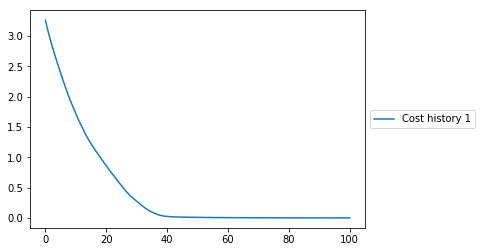

In [11]:
plot_cost_histories(cost_histories=[cost_history], labels=["Cost history 1"])

In [12]:
best_idx = np.argmin(cost_history)
best_weight = weight_history[best_idx]

In [13]:
def fusion_rule(x, w):
    return np.argmax(model(x, w))

In [19]:
points_count = len(x)

miscounts = 0
for p in range(points_count):
    x_val = np.array([x[p, 0], x[p, 1]])
    if fusion_rule(x_val, best_weight) != y[p]:
        miscounts = miscounts + 1

print("Out of {0} points, the number of misclassifications is {1}".format(points_count, miscounts))

Out of 70 points, the number of misclassifications is 2
